# Project 3: Species distribution modeling with multimodal satellite and environmental data

In the following notebook, we will use three data modalities:

*   Climatic tabular variables
*   Satellite time series
*   Satellite imagery

to predict the distribution of 342 plant species across Europe.

This will be done using ...

## 1. Setup

### 1.1 Install dependencies

In [1]:
!pip install -U -q torch==2.5.0 torchvision matplotlib tqdm gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install folium


### 1.2 Check if GPU available

PyTorch has full support for GPUs and we will make use of it already in this exercise. So let's first test if you have GPU availability.

Run the following code block. It should be `False` when running locally (unless you have a GPU), and `True` on Colab

If you get `False` and you are in Colab, click on Runtime tab and select GPU hardware accelerator

In [3]:
import torch
print(torch.cuda.is_available())

True


## 2. Data Loading

Here, we get the different datasets and write some code to make it accessible to our prospective DL model.

### 2.1 Download data

Let's download the data for this project!

In [4]:
# import os
# os.getcwd()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Set this to YOUR folder
base_path = "/content/drive/MyDrive/IPEO/Project/"

os.chdir(base_path)
print(os.getcwd())

# ---- CSV files ----
env_train = pd.read_csv("data/env_variables_training.csv")
env_test  = pd.read_csv("data/env_variables_test.csv")

ts_train  = pd.read_csv("data/landsat_timeseries_training.csv")
ts_test   = pd.read_csv("data/landsat_timeseries_test.csv")

# ---- Numpy files ----
img_train = np.load("data/satellite_patches_training.npy")
img_test  = np.load("data/satellite_patches_test.npy")

species_train = np.load("data/species_data_training.npy")
species_test  = np.load("data/species_data_test.npy")

print("Training shapes:")
print("Env:", env_train.shape)
print("Time-series:", ts_train.shape)
print("Images:", img_train.shape)
print("Labels:", species_train.shape)


/content/drive/MyDrive/IPEO/Project
Training shapes:
Env: (5000, 22)
Time-series: (5000, 161)
Images: (5000, 3, 128, 128)
Labels: (5000, 342)


Now let's reshape and standardize outputs:

In [27]:
# Extract coordinates
train_lons = env_train.iloc[:, 1]   # 2nd column = longitude
train_lats = env_train.iloc[:, 2]   # 3rd column = latitude

test_lons = env_test.iloc[:, 1]
test_lats = env_test.iloc[:, 2]

# Convert pandas → numpy arrays
env_train = env_train.values.astype(np.float32)
env_test  = env_test.values.astype(np.float32)

# ---- Remove first 3 columns (geolocation data) from env_train and env_test ----
env_train = env_train[:, 3:]
env_test  = env_test[:, 3:]

mean_env = env_train.mean(axis=0)
std_env = env_train.std(axis=0)
env_train = (env_train - mean_env) / std_env
env_test = (env_test - mean_env) / std_env
n_env_features = env_train.shape[1]
print(f"Number of environmental features: {n_env_features}")

ts_train = ts_train.values.astype(np.float32)
ts_test  = ts_test.values.astype(np.float32)

# ---- FIX: drop extra column in time-series ----
# Keep 160 values, starting from the second column (index 1) → reshape into (40,4)
ts_train = ts_train[:, 1:161].reshape(-1, 40, 4)
ts_test  = ts_test[:, 1:161].reshape(-1, 40, 4)

mean_ts = ts_train.mean(axis=(0, 1))
std_ts = ts_train.std(axis=(0, 1))
ts_train = (ts_train - mean_ts) / std_ts
ts_test = (ts_test - mean_ts) / std_ts

# Images are already (N,3,128,128), but need to be normalized
img_train = img_train.astype(np.float32)/255.0
img_test  = img_test.astype(np.float32)/255.0

# Labels
species_train = species_train.astype(np.float32)
species_test  = species_test.astype(np.float32)

print("Env train shape after removing first 3 columns:", env_train.shape)
print("Env test shape after removing first 3 columns:", env_test.shape)
print("Time-series shape:", ts_train.shape) # should be (5000, 40, 4)

Number of environmental features: 19
Env train shape after removing first 3 columns: (5000, 19)
Env test shape after removing first 3 columns: (1000, 19)
Time-series shape: (5000, 40, 4)


### 2.2 define a dataset class

In [28]:
from sklearn.model_selection import train_test_split

class GeoPlantDataset(Dataset):
    def __init__(self, images, timeseries, tabular, labels, split='train', val_split=0.2, random_state=42):
        """
        Args:
            images: numpy array of satellite images
            timeseries: numpy array of time series data
            tabular: numpy array of environmental variables
            labels: numpy array of species labels
            split: 'train', 'val', or 'test'
            val_split: fraction of training data to use for validation (default 0.2)
            random_state: random seed for reproducibility
        """
        self.split = split

        # If this is test data, use it as-is
        if split == 'test':
            self.images = images
            self.timeseries = timeseries
            self.tabular = tabular
            self.labels = labels
        else:
            # Split training data into train and validation
            indices = np.arange(len(labels))
            train_idx, val_idx = train_test_split(
                indices,
                test_size=val_split,
                random_state=random_state
            )

            if split == 'train':
                self.images = images[train_idx]
                self.timeseries = timeseries[train_idx]
                self.tabular = tabular[train_idx]
                self.labels = labels[train_idx]
            elif split == 'val':
                self.images = images[val_idx]
                self.timeseries = timeseries[val_idx]
                self.tabular = tabular[val_idx]
                self.labels = labels[val_idx]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx])     # (3,H,W)
        ts  = torch.tensor(self.timeseries[idx]) # (40,4)
        tab = torch.tensor(self.tabular[idx])    # (19,)
        y   = torch.tensor(self.labels[idx])     # (342,)
        return img, ts, tab, y

Finally we can define the dataset and load the data:

In [29]:
# Create datasets with train/val split
train_dataset = GeoPlantDataset(
    images=img_train,
    timeseries=ts_train,
    tabular=env_train,
    labels=species_train,
    split='train',
    val_split=0.2
)

val_dataset = GeoPlantDataset(
    images=img_train,
    timeseries=ts_train,
    tabular=env_train,
    labels=species_train,
    split='val',
    val_split=0.2
)

test_dataset = GeoPlantDataset(
    images=img_test,
    timeseries=ts_test,
    tabular=env_test,
    labels=species_test,
    split='test'
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 4000
Val samples: 1000
Test samples: 1000


Quick test to be sure we did everything right 😉

It should look something like this:

```
Image: torch.Size([3, H, W])
Time series: torch.Size([40, 4])
Tabular: torch.Size([19])
Label: torch.Size([342])
```




In [30]:
img, ts, tab, y = train_dataset[0]

print("Image:", img.shape)
print("Time series:", ts.shape)
print("Tabular:", tab.shape)
print("Label:", y.shape)

Image: torch.Size([3, 128, 128])
Time series: torch.Size([40, 4])
Tabular: torch.Size([19])
Label: torch.Size([342])


### 2.3 Look at the data

Before we start with the model, its important to have a rough idea, what the data looks like. How often does each species appear? Are there over-/underrepresented species? Etc.

#### Visualize species appearence in the first 50 samples

Shape of species_train: (5000, 342)


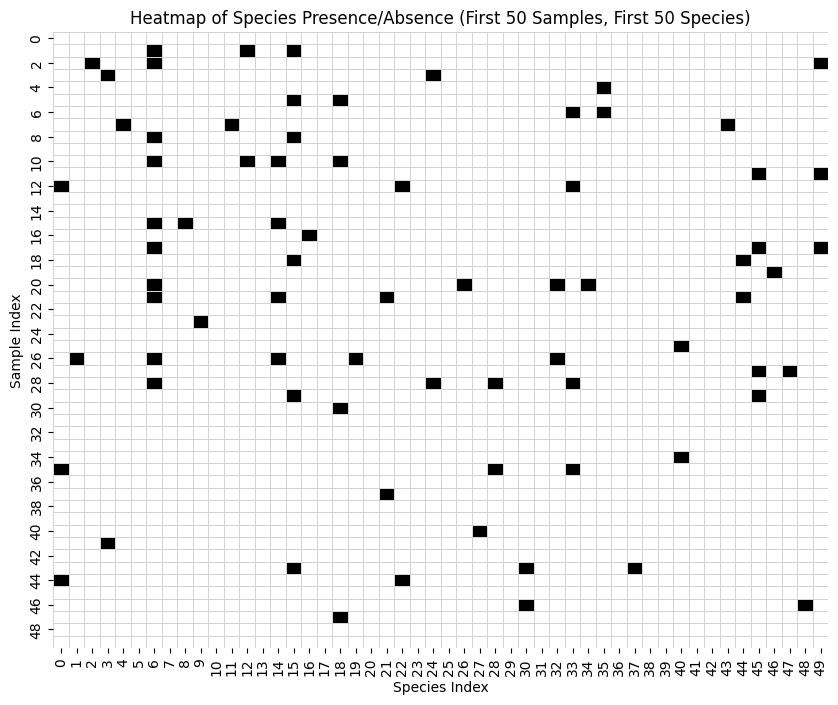

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(f"Shape of species_train: {species_train.shape}")

# Visualize a subset of the species_train matrix as a heatmap
# For better readability, we'll take the first 50 samples and the first 50 species
subset_species_train = species_train[:50, :50]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_species_train, cmap="binary", cbar=False, linewidths=.5, linecolor='lightgrey')
plt.title('Heatmap of Species Presence/Absence (First 50 Samples, First 50 Species)')
plt.xlabel('Species Index')
plt.ylabel('Sample Index')
plt.show()

#### Visualize a Satellite Patch


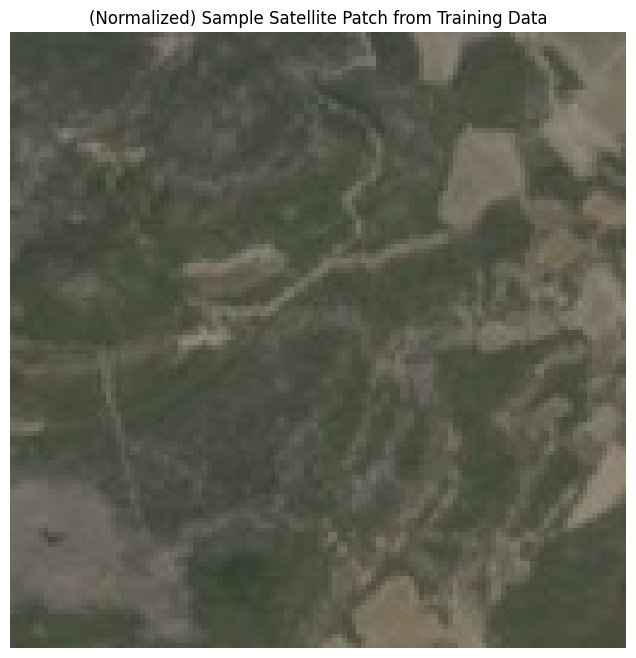

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Select the first satellite patch from the training data
sample_image = img_train[0]

# Transpose the image from (C, H, W) to (H, W, C) for plotting with matplotlib
# Assuming the channels are RGB (3, 128, 128)
plot_image = np.transpose(sample_image, (1, 2, 0))

# Normalize the image data to [0, 1] if it's not already (e.g., if it's 0-255)
# Based on the earlier cell content, the images are float32, so assuming normalization is needed.
plot_image = plot_image # Assuming pixel values are 0-1

# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(plot_image)
plt.title('(Normalized) Sample Satellite Patch from Training Data')
plt.axis('off') # Hide axes for a cleaner image display
plt.show()

#### Visualize occurence of each species

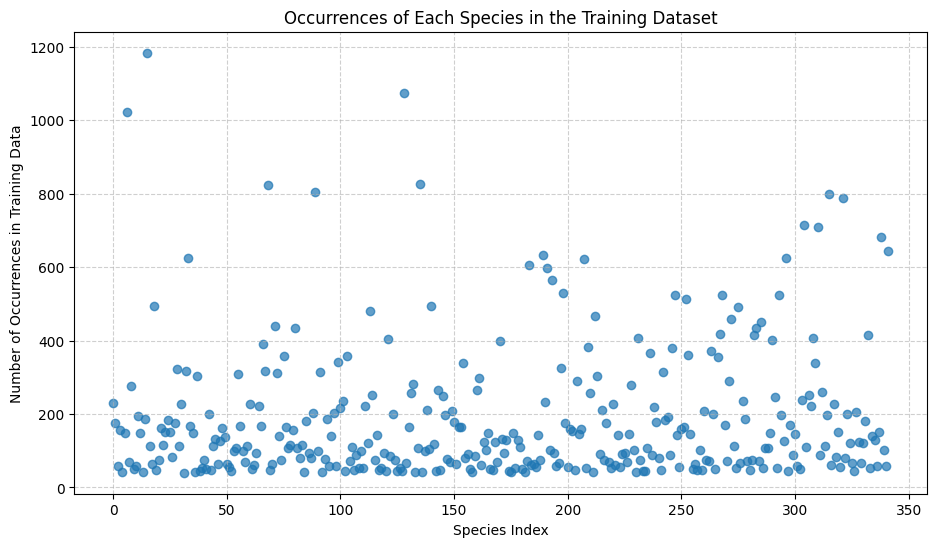

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the occurrence count for each species in the training dataset
species_counts = species_train.sum(axis=0)

# Create a scatter plot
plt.figure(figsize=(11, 6))
plt.scatter(range(len(species_counts)), species_counts, alpha=0.7)
plt.xlabel('Species Index')
plt.ylabel('Number of Occurrences in Training Data')
plt.title('Occurrences of Each Species in the Training Dataset')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Visualize the data points on a map

In [34]:
import folium

# Center of the map = mean of coordinates
center_lat = pd.concat([train_lats, test_lats]).mean()
center_lon = pd.concat([train_lons, test_lons]).mean()

# Create map
m = folium.Map(location=[center_lat, center_lon], zoom_start=4)

# Add training points (blue)
for lat, lon in zip(train_lats, train_lons):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Add test points (red)
for lat, lon in zip(test_lats, test_lons):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m


Output hidden; open in https://colab.research.google.com to view.

## 3. Multimodal Species Distribution Model

Because we have multiple data modalities, they each need to be treated by a sepcific encoder and later combined into a single model.

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------
# 3.1 TABULAR ENCODER (climate variables)
# ------------------------------------------------------------
class TabularEncoder(nn.Module):
    def __init__(self, in_features=19, out_features=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, out_features),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3.2 TEMPORAL ENCODER (Landsat quarterly 10-year series)
#      Input shape: (batch, T=40, C=4)
# ------------------------------------------------------------
class TemporalEncoder(nn.Module):
    def __init__(self, in_channels=4, hidden=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden*2, hidden*2, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(hidden*2, 128)

    def forward(self, ts):
        # ts shape: (B, T, C) → transpose to (B, C, T)
        ts = ts.permute(0, 2, 1)
        h = self.conv(ts)                         # (B, hidden*2, T)
        h = torch.mean(h, dim=-1)                 # global average pooling on time dimension
        return self.fc(h)                         # (B, 128)


# ------------------------------------------------------------
# 3.3 IMAGE ENCODER (Sentinel-2 RGB patches)
#      Uses pretrained ResNet34 but outputs a 256-dim feature
# ------------------------------------------------------------
from torchvision.models import resnet34

class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet34(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # remove linear head
        self.proj = nn.Linear(512, 256)

    def forward(self, img):
        # img: (B,3,H,W)
        h = self.backbone(img)                 # (B, 512, 1, 1)
        h = torch.flatten(h, 1)                # (B, 512)
        return self.proj(h)                    # (B, 256)


# ------------------------------------------------------------
# 3.4 FUSION MODEL
# ------------------------------------------------------------
class MultimodalSpeciesModel(nn.Module):
    def __init__(self, num_species=342):
        super().__init__()
        self.tabular = TabularEncoder()
        self.temporal = TemporalEncoder()
        self.image   = ImageEncoder()

        # fused feature size = 64 + 128 + 256 = 448
        fusion_dim = 64 + 128 + 256

        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_species)
        )

    def forward(self, img, ts, tab):
        f_img = self.image(img)
        f_ts  = self.temporal(ts)
        f_tab = self.tabular(tab)

        fused = torch.cat([f_img, f_ts, f_tab], dim=1)
        logits = self.fusion(fused)
        return logits  # outputs unnormalized logits for 342 species


# instantiate the model
model = MultimodalSpeciesModel()
print("Multimodal model created with parameters:", sum(p.numel() for p in model.parameters()))

Multimodal model created with parameters: 21923734


## 4. Training the model

Before actually training the model, we need to take care of the imbalance in species occurence. This is done by computing the class weights for the criterion (BCE loss).

In [49]:
def compute_class_weights(train_labels):
    """
    train_labels: numpy array shape (N, 342)
    """
    positives = train_labels.sum(axis=0)          # (342,)
    negatives = len(train_labels) - positives     # (342,)

    # avoid division by zero → weight = 1.0 if no positives
    pos_weight = np.where(positives > 0, negatives / (positives + 1e-6), 1.0)
    return torch.tensor(pos_weight, dtype=torch.float32)

pos_weight = compute_class_weights(train_dataset.labels)

In [50]:
from sklearn.metrics import roc_auc_score

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

#criterion = nn.BCEWithLogitsLoss()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [51]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for env, ts, img, y in loader:
        env = env.to(device).float()
        ts = ts.to(device).float()
        img = img.to(device).float()
        y = y.to(device).float()

        optimizer.zero_grad()

        preds = model(env, ts, img)  # (B, 342)
        loss = criterion(preds, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [52]:
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for env, ts, img, y in loader:
            env = env.to(device).float()
            ts = ts.to(device).float()
            img = img.to(device).float()

            preds = torch.sigmoid(model(env, ts, img))  # convert logits → probabilities

            y = y.to(device).float()
            preds = model(env, ts, img)  # (B, 342)
            loss = criterion(preds, y)
            total_loss += loss.item()

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    species_auc = []
    for i in range(all_labels.shape[1]):
        if all_labels[:, i].sum() == 0:  # no positives → skip
            continue
        auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        species_auc.append(auc)

    mean_auc = sum(species_auc) / len(species_auc)

    return mean_auc, total_loss/len(loader)


In [53]:
EPOCHS = 20

train_loss_list = []
val_loss_list = []
auc_list = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_auc, val_loss = evaluate(model, val_loader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    auc_list.append(val_auc)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train_Loss: {train_loss:.4f} | Val_Loss: {val_loss:.4f} Val_Mean AUC: {val_auc:.4f}")


Epoch 1/20 | Train_Loss: 1.3139 | Val_Loss: 1.2349 Val_Mean AUC: 0.6888
Epoch 2/20 | Train_Loss: 1.1762 | Val_Loss: 1.1348 Val_Mean AUC: 0.7425
Epoch 3/20 | Train_Loss: 1.0418 | Val_Loss: 1.0449 Val_Mean AUC: 0.7803
Epoch 4/20 | Train_Loss: 0.9309 | Val_Loss: 1.1190 Val_Mean AUC: 0.7770
Epoch 5/20 | Train_Loss: 0.8513 | Val_Loss: 1.0253 Val_Mean AUC: 0.7984
Epoch 6/20 | Train_Loss: 0.7747 | Val_Loss: 1.0727 Val_Mean AUC: 0.7964
Epoch 7/20 | Train_Loss: 0.7096 | Val_Loss: 1.1851 Val_Mean AUC: 0.7981
Epoch 8/20 | Train_Loss: 0.6605 | Val_Loss: 1.1896 Val_Mean AUC: 0.8029
Epoch 9/20 | Train_Loss: 0.6203 | Val_Loss: 1.2043 Val_Mean AUC: 0.8071
Epoch 10/20 | Train_Loss: 0.5890 | Val_Loss: 1.2167 Val_Mean AUC: 0.8069
Epoch 11/20 | Train_Loss: 0.5777 | Val_Loss: 1.2501 Val_Mean AUC: 0.8018
Epoch 12/20 | Train_Loss: 0.5552 | Val_Loss: 1.3318 Val_Mean AUC: 0.8061
Epoch 13/20 | Train_Loss: 0.5356 | Val_Loss: 1.3812 Val_Mean AUC: 0.8060
Epoch 14/20 | Train_Loss: 0.5176 | Val_Loss: 1.3446 Val_Mean

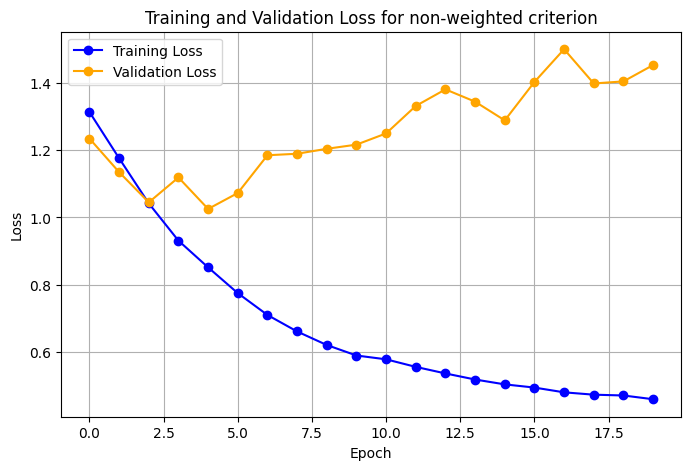

In [54]:
plt.figure(figsize=(8,5))
plt.plot(train_loss_list, label='Training Loss', color='blue', marker='o')
plt.plot(val_loss_list, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for non-weighted criterion')
plt.legend()
plt.grid(True)
plt.savefig(f"Models/Initial_model/Loss_weighted.png", dpi=300)
plt.show()



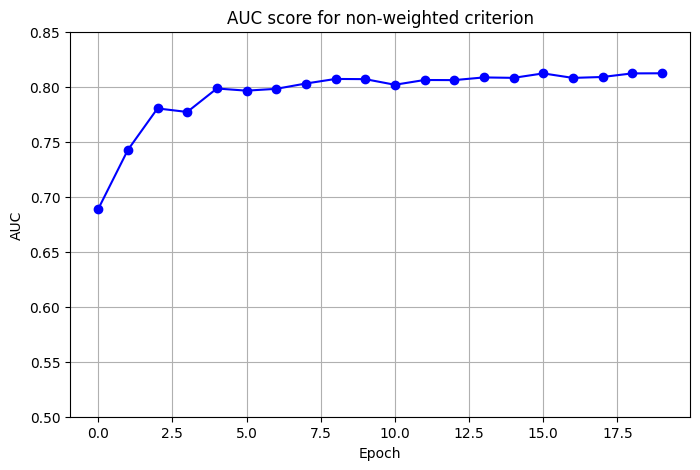

In [55]:
plt.figure(figsize=(8,5))
plt.plot(auc_list, color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC score for non-weighted criterion')
plt.ylim(0.5, .85)
plt.grid(True)
plt.savefig(f"Models/Initial_model/ROC_AUC_weighted.png", dpi=300)

plt.show()

Run this cell only if you want to save the model. Choose a descriptive name

In [56]:
import os

# Path to your data folder in Google Drive
#save_dir = base_path
save_dir = "Models/Initial_model"

# create folder if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# choose your filename
model_name = "Initial_model_weighted.pth"

save_path = os.path.join(save_dir, model_name)

torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to Models/Initial_model/Initial_model_weighted.pth


## 5. Test the model

In case you want to load a specific model, run the cell below

In [58]:
import os
save_dir = "Models/Initial_model"
# choose your model you want to test
model_name = "Initial_model_normal.pth"
save_path = os.path.join(save_dir, model_name)

model_normal = MultimodalSpeciesModel()
model_normal.load_state_dict(torch.load(save_path, map_location="cpu"))


model_name = "Initial_model_weighted.pth"
save_path = os.path.join(save_dir, model_name)

model_weighted = MultimodalSpeciesModel()
model_weighted.load_state_dict(torch.load(save_path, map_location="cpu"))

/tmp/ipython-input-931681569.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_normal.load_state_dict(torch.load(save_path, map_location="cpu"))
/tmp/ipython-input-9

<All keys matched successfully>

In [59]:
import torch
import numpy as np

def test_model(model, loader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for env, ts, img, y in loader:

            env = env.to(device).float()
            ts = ts.to(device).float()
            img = img.to(device).float()

            # model outputs logits (shape: batch × 342)
            logits = model(env, ts, img)
            probs = torch.sigmoid(logits)       # convert to probabilities

            all_preds.append(probs.cpu())
            all_labels.append(y)               # y is already CPU numpy/tensor

    all_preds = torch.cat(all_preds).numpy()    # shape (N, 342)
    all_labels = torch.cat(all_labels).numpy()  # shape (N, 342)

    return all_preds, all_labels


Here I chose to test the weighted model (model_weighted)

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model_weighted.to(device)

all_preds_W, all_labels_W = test_model(model, test_loader, device)


In [61]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
model = model_normal.to(device)

all_preds_N, all_labels_N = test_model(model, test_loader, device)


## 6. Evaluate the model

### 6.1 AUC per species

In [62]:
from sklearn.metrics import roc_auc_score
import numpy as np

def compute_auc_scores(all_labels, all_preds):
    auc_scores = []
    for i in range(all_labels.shape[1]):
        y_true = all_labels[:, i]
        y_pred = all_preds[:, i]

        # skip species with no positives (cannot compute AUC)
        if y_true.sum() == 0 or y_true.sum() == len(y_true):
            continue

        auc = roc_auc_score(y_true, y_pred)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    return mean_auc, auc_scores

mean_auc_W, auc_scores_W = compute_auc_scores(all_labels_W, all_preds_W)
mean_auc_N, auc_scores_N = compute_auc_scores(all_labels_N, all_preds_N)
print("Mean AUC across species (for weighted model):", mean_auc_W)
print("Mean AUC across species (for non-weighted model):", mean_auc_N)

Mean AUC across species (for weighted model): 0.7901638420127302
Mean AUC across species (for non-weighted model): 0.77283981818999


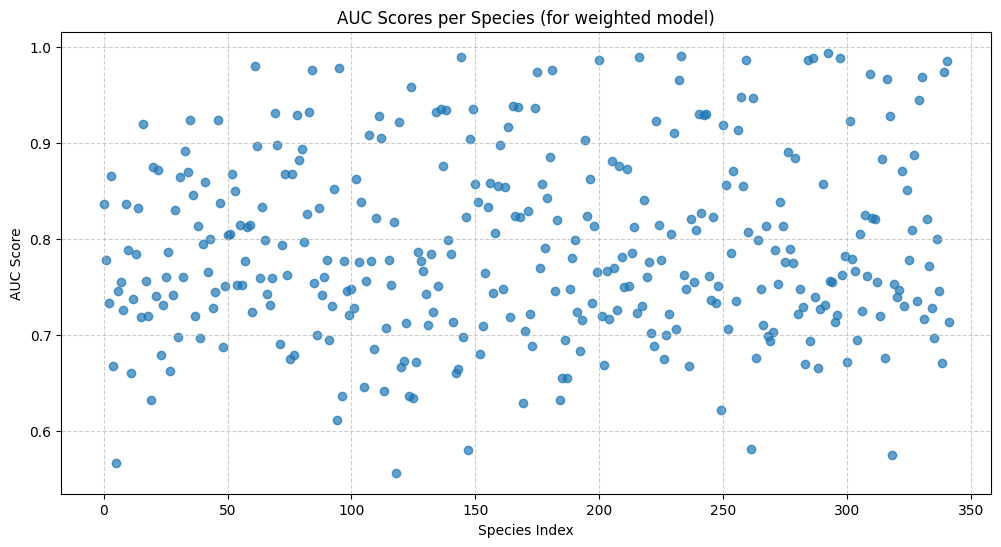

In [63]:
import matplotlib.pyplot as plt

# Create a scatter plot of auc_scores
plt.figure(figsize=(12, 6))
plt.scatter(range(len(auc_scores_W)), auc_scores_W, alpha=0.7)
plt.xlabel('Species Index')
plt.ylabel('AUC Score')
plt.title('AUC Scores per Species (for weighted model)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Lets find if the AUC score is dependent on the frequency in which a species has appeared in the training data. For that we will plot the AUC score of both models (weighted and non-weighted) in increasing order of appearence of a species.


In [64]:
# find out how much time the species have appeared in the training data
species_occurrence_counts = np.sum(species_train, axis=0)

# then order the list
sorted_indices = np.argsort(species_occurrence_counts)

# apply it to the different models
rearranged_auc_scores_W = np.array(auc_scores_W)[sorted_indices]
rearranged_auc_scores_N = np.array(auc_scores_N)[sorted_indices]
rearranged_species_occurrence_counts = species_occurrence_counts[sorted_indices]

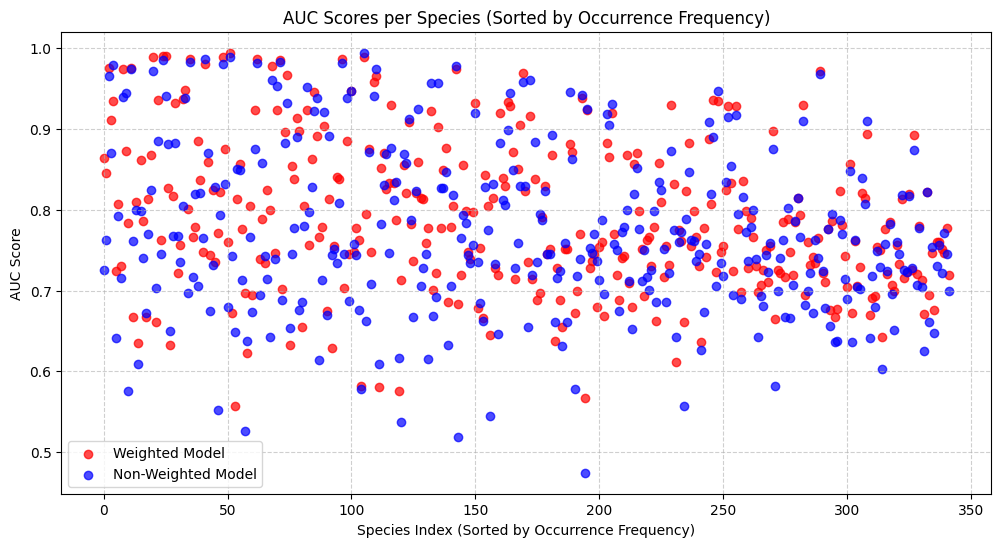

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(range(len(rearranged_auc_scores_W)), rearranged_auc_scores_W, alpha=0.7, color='red')
plt.scatter(range(len(rearranged_auc_scores_N)), rearranged_auc_scores_N, alpha=0.7, color='blue')
plt.xlabel('Species Index (Sorted by Occurrence Frequency)')
plt.ylabel('AUC Score')
plt.title('AUC Scores per Species (Sorted by Occurrence Frequency)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(f"Models/Initial_model/AUC_score_per_species.png", dpi=300)
plt.legend(['Weighted Model', 'Non-Weighted Model'])
plt.show()

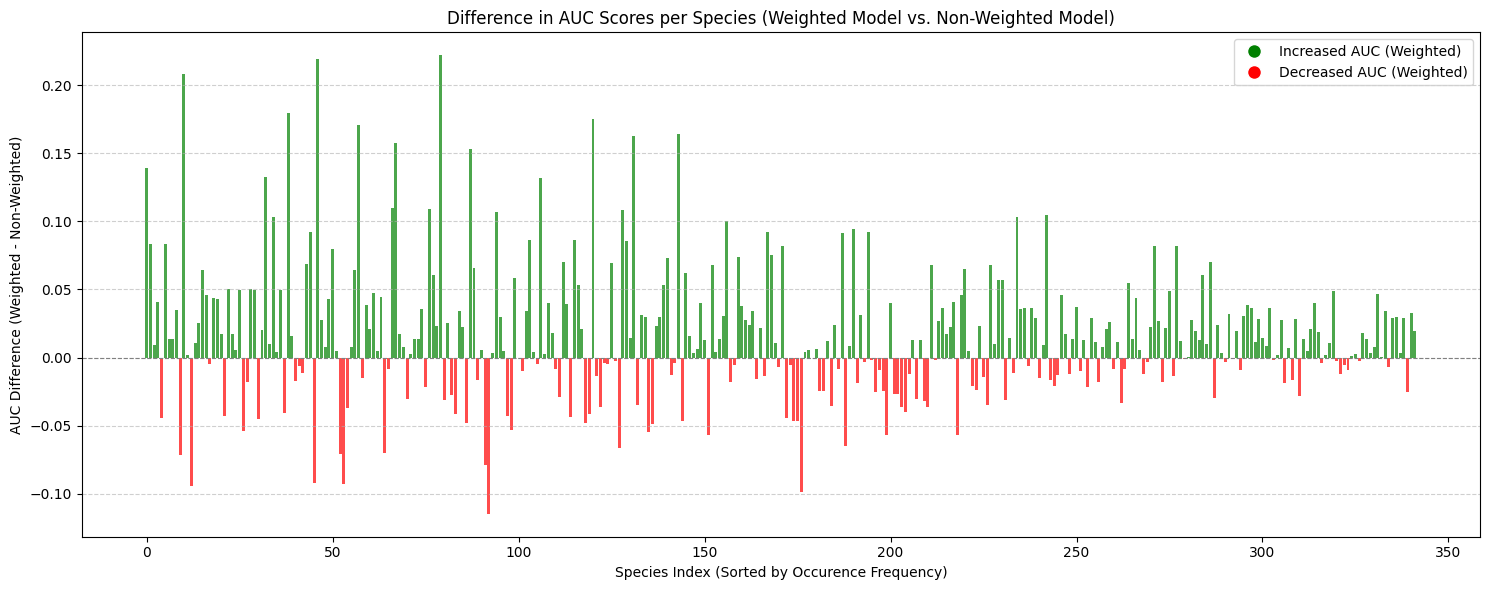

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the difference in AUC scores (Weighted - Non-Weighted)
auc_difference = np.array(rearranged_auc_scores_W) - np.array(rearranged_auc_scores_N)

# Create a figure and an axes object
plt.figure(figsize=(15, 6))

# Plot the differences as a bar chart
# Use different colors for positive and negative differences to highlight increases/decreases
colors = ['green' if diff > 0 else 'red' for diff in auc_difference]
plt.bar(range(len(auc_difference)), auc_difference, color=colors, alpha=0.7)

plt.xlabel('Species Index (Sorted by Occurence Frequency)')
plt.ylabel('AUC Difference (Weighted - Non-Weighted)')
plt.title('Difference in AUC Scores per Species (Weighted Model vs. Non-Weighted Model)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Add a line at y=0 for reference

# Create a custom legend for positive and negative changes
positive_patch = plt.Line2D([0], [0], marker='o', color='w', label='Increased AUC (Weighted)',
                          markerfacecolor='green', markersize=10)
negative_patch = plt.Line2D([0], [0], marker='o', color='w', label='Decreased AUC (Weighted)',
                          markerfacecolor='red', markersize=10)
plt.legend(handles=[positive_patch, negative_patch])

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig(f"Models/Initial_model/Difference_AUC_score.png", dpi=300)
plt.tight_layout()
plt.show()

### 6.2 Compute Precision, Recall, F1 and more

Before we compute those metrics, lets refresh our memories on what those really are.

*   Precision : How many of the predicted data points were correctly predicted
*   Recall : How many of our ground thruths have been correctly predicted
*   F1 : the average of precision and recall

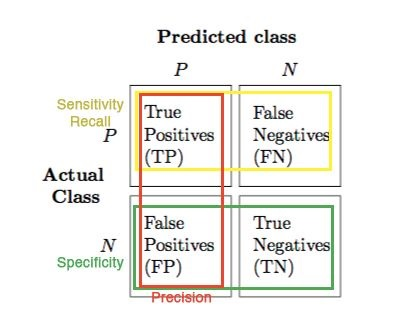




0ef9c82f-2857-446e-918d-5f654b9d9133_Screenshot+(49).avif

In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import label_ranking_loss

def full_evaluation(all_labels, all_preds):
    binary_preds = (all_preds >= 0.5).astype(int)

    mean_auc, auc_scores = compute_auc_scores(all_labels, all_preds)

    macro_f1 = f1_score(all_labels, binary_preds, average='macro')
    micro_f1 = f1_score(all_labels, binary_preds, average='micro')

    macro_precision = precision_score(all_labels, binary_preds, average='macro')
    macro_recall    = recall_score(all_labels, binary_preds, average='macro')

    subset_acc = (binary_preds == all_labels).all(axis=1).mean()

    rank_loss = label_ranking_loss(all_labels, all_preds)

    return {
        "Mean AUC": mean_auc,
        "Macro F1": macro_f1,
        "Micro F1": micro_f1,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Subset Accuracy": subset_acc,
        "Ranking Loss": rank_loss,
        "Per-species AUCs": auc_scores
    }


**macro**: treat each species equally (good when species are imbalanced)

**micro**: treat each observation equally (biased toward frequent species)

Lets compare the metrics for both models

In [70]:
results = full_evaluation(all_labels_W, all_preds_W)
print("Metrics for weighted model:")
for k,v in results.items():
    if k != "Per-species AUCs":
        print(k, ":", v)

Metrics for weighted model:
Mean AUC : 0.7901638420127302
Macro F1 : 0.19627543609128195
Micro F1 : 0.23105957004540234
Macro Precision : 0.13163537760707011
Macro Recall : 0.4520445375881399
Subset Accuracy : 0.001
Ranking Loss : 0.16493071558797048


In [71]:
results = full_evaluation(all_labels_N, all_preds_N)
print("Metrics for non-weighted model:")
for k,v in results.items():
    if k != "Per-species AUCs":
        print(k, ":", v)

Metrics for non-weighted model:
Mean AUC : 0.77283981818999
Macro F1 : 0.04365533327485676
Micro F1 : 0.09961527892278098
Macro Precision : 0.15904771980919444
Macro Recall : 0.029354702700532587
Subset Accuracy : 0.027
Ranking Loss : 0.16784944439608562


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can clearly see the increase in the macro Precision, macro Recall and therefore macro F1 with the weighted model.

### 6.3 compute optimal threshold for each species

In [72]:
import numpy as np
from sklearn.metrics import f1_score

def tune_thresholds(all_labels, all_preds, metric="f1"):
    """
    all_labels: (N, 342)
    all_preds:  (N, 342)

    Returns:
    thresholds: list of 342 optimal thresholds
    """
    thresholds = []
    num_species = all_labels.shape[1]

    for i in range(num_species):
        y_true = all_labels[:, i]
        y_prob = all_preds[:, i]

        # Skip species with no positives
        if y_true.sum() == 0:
            thresholds.append(0.5)
            continue

        # try thresholds between 0 and 1
        candidate_thresholds = np.linspace(0.05, 0.95, 19)
        best_score = -1
        best_thr = 0.5

        for thr in candidate_thresholds:
            y_pred = (y_prob >= thr).astype(int)

            if metric == "f1":
                score = f1_score(y_true, y_pred, zero_division=0)
            elif metric == "jstat":
                # Youden J = TP_rate - FP_rate
                tp = ((y_pred == 1) & (y_true == 1)).sum()
                fn = ((y_pred == 0) & (y_true == 1)).sum()
                fp = ((y_pred == 1) & (y_true == 0)).sum()
                tn = ((y_pred == 0) & (y_true == 0)).sum()

                tpr = tp / (tp + fn + 1e-6)
                fpr = fp / (fp + tn + 1e-6)
                score = tpr - fpr
            else:
                raise ValueError("Unknown metric for threshold tuning")

            if score > best_score:
                best_score = score
                best_thr = thr

        thresholds.append(best_thr)

    print("Threshold tuning complete.")
    return np.array(thresholds)

thresholds_W = tune_thresholds(all_labels_W, all_preds_W, metric="f1")


Threshold tuning complete.


In [73]:
def apply_thresholds(all_preds, thresholds):
    tuned_preds = (all_preds >= thresholds[None, :]).astype(int)
    return tuned_preds

tuned_binary_preds_W = apply_thresholds(all_preds_W, thresholds_W)


In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import label_ranking_loss
from sklearn.metrics import roc_auc_score

def full_evaluation_w_tuned_thresholds(all_labels, all_preds, tuned_binary_preds):
    mean_auc, auc_scores = compute_auc_scores(all_labels, all_preds)

    macro_f1 = f1_score(all_labels, tuned_binary_preds, average='macro')
    micro_f1 = f1_score(all_labels, tuned_binary_preds, average='micro')

    macro_precision = precision_score(all_labels, tuned_binary_preds, average='macro')
    macro_recall    = recall_score(all_labels, tuned_binary_preds, average='macro')

    subset_acc = (tuned_binary_preds == all_labels).all(axis=1).mean()

    rank_loss = label_ranking_loss(all_labels, all_preds)

    return {
        "Mean AUC": mean_auc,
        "Macro F1": macro_f1,
        "Micro F1": micro_f1,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Subset Accuracy": subset_acc,
        "Ranking Loss": rank_loss,
        "Per-species AUCs": auc_scores
    }

results = full_evaluation_w_tuned_thresholds(all_labels_W, all_preds_W, tuned_binary_preds_W)
for k,v in results.items():
    if k != "Per-species AUCs":
        print(k, ":", v)


Mean AUC : 0.7901638420127302
Macro F1 : 0.24662328318792692
Micro F1 : 0.2695904122217832
Macro Precision : 0.23270297029563466
Macro Recall : 0.39940744840485254
Subset Accuracy : 0.003
Ranking Loss : 0.16493071558797048


### gradient based importance of each modality

In [75]:
def prepare_inputs_for_gradients(img, ts, tab, device):
    img = img.to(device).float()
    ts  = ts.to(device).float()
    tab = tab.to(device).float()

    img.requires_grad = True
    ts.requires_grad  = True
    tab.requires_grad = True

    return img, ts, tab

def compute_gradients(model, img, ts, tab, species_id):
    model.eval()

    logits = model(img, ts, tab)            # shape (1, 342)
    target_logit = logits[0, species_id]     # scalar

    model.zero_grad()
    target_logit.backward()

    return img.grad.clone(), ts.grad.clone(), tab.grad.clone()

def gradient_x_input(img, ts, tab, g_img, g_ts, g_tab):
    return (
        (img * g_img).detach(),
        (ts  * g_ts).detach(),
        (tab * g_tab).detach()
    )

def explain_sample(model, img, ts, tab, species_id, device="cuda"):

    # 1. enable gradients
    img, ts, tab = prepare_inputs_for_gradients(img, ts, tab, device)

    # 2. compute gradients wrt inputs
    g_img, g_ts, g_tab = compute_gradients(model, img, ts, tab, species_id)

    # 3. gradient × input attributions
    a_img, a_ts, a_tab = gradient_x_input(img, ts, tab, g_img, g_ts, g_tab)

    # 4. modality-level importance scores
    score_img = a_img.abs().mean().item()
    score_ts  = a_ts.abs().mean().item()
    score_tab = a_tab.abs().mean().item()

    modality_scores = {
        "image_importance": score_img,
        "time_series_importance": score_ts,
        "tabular_importance": score_tab
    }

    return a_img, a_ts, a_tab, modality_scores


In [76]:
img, ts, tab, label = next(iter(test_loader))
img = img[0].unsqueeze(0)   # pick sample 0 in the batch
ts  = ts[0].unsqueeze(0)
tab = tab[0].unsqueeze(0)

species_id = 25   # choose a species to explain

model = model_weighted.to(device)

a_img, a_ts, a_tab, modality_scores = explain_sample(
    model, img, ts, tab, species_id, device
)
print("Gradient based importance for weighted model:")
print(modality_scores)

model = model_normal.to(device)

a_img, a_ts, a_tab, modality_scores = explain_sample(
    model, img, ts, tab, species_id, device
)
print("Gradient based importance for non-weighted model:")
print(modality_scores)


Gradient based importance for weighted model:
{'image_importance': 0.06482163071632385, 'time_series_importance': 0.0023367214016616344, 'tabular_importance': 0.028180694207549095}
Gradient based importance for non-weighted model:
{'image_importance': 0.044486552476882935, 'time_series_importance': 3.5730332026417955e-09, 'tabular_importance': 0.018558533862233162}


#### Compare modality importance across species

In [77]:
def get_modality_importance(model, img, ts, tab, species_id, device):

    img = img.to(device).float()
    ts  = ts.to(device).float()
    tab = tab.to(device).float()

    img.requires_grad = True
    ts.requires_grad  = True
    tab.requires_grad = True

    model.eval()
    logits = model(img, ts, tab)
    target_logit = logits[:, species_id].mean()

    model.zero_grad()
    target_logit.backward()

    # gradient × input
    gxi_img = (img * img.grad).detach()
    gxi_ts  = (ts  * ts.grad).detach()
    gxi_tab = (tab * tab.grad).detach()

    # reduce to scalar importance
    score_img = gxi_img.abs().mean(dim=(1,2,3))   # (batch,)
    score_ts  = gxi_ts.abs().mean(dim=(1,2))      # (batch,)
    score_tab = gxi_tab.abs().mean(dim=1)         # (batch,)

    return score_img.cpu(), score_ts.cpu(), score_tab.cpu()

def compute_modality_importance_across_species(model, loader, num_species, device="cuda"):
    """
    Compute average gradient×input modality importance across all species
    using the `get_modality_importance` function.
    """
    model.eval()

    # store importance scores
    modality_importance = {
        "image":   np.zeros(num_species),
        "ts":      np.zeros(num_species),
        "tabular": np.zeros(num_species),
        "counts":  np.zeros(num_species)  # number of samples where species appears
    }

    for img, ts, tab, labels in loader:

        # compute gradient×input scores for this batch
        score_img, score_ts, score_tab = get_modality_importance(
            model, img, ts, tab, species_id=None, device=device
        )

        # Loop over species and accumulate only for species present in batch
        batch_size = labels.shape[0]
        for s in range(num_species):
            present_mask = labels[:, s] > 0  # samples where this species appears
            count = present_mask.sum().item()
            if count == 0:
                continue

            modality_importance["image"][s]   += score_img[present_mask].sum().item()
            modality_importance["ts"][s]      += score_ts[present_mask].sum().item()
            modality_importance["tabular"][s] += score_tab[present_mask].sum().item()
            modality_importance["counts"][s]  += count

    # average by counts per species
    for key in ["image", "ts", "tabular"]:
        modality_importance[key] /= (modality_importance["counts"] + 1e-9)

    return modality_importance


In [78]:
def compute_modality_importance_across_species(model, test_loader, num_species, device="cuda"):

    # store importance scores for each species
    modality_importance = {
        "image":   np.zeros(num_species),
        "ts":      np.zeros(num_species),
        "tabular": np.zeros(num_species),
        "counts":  np.zeros(num_species)  # count samples where species appears
    }

    for img, ts, tab, labels in test_loader:

        labels = labels.numpy()  # shape: (batch, 342)

        for s in range(num_species):
            if labels[:, s].sum() == 0:
                continue  # skip species not present in this batch

            img_s, ts_s, tab_s = img.clone(), ts.clone(), tab.clone()

            imp_img, imp_ts, imp_tab = get_modality_importance(
                model, img_s, ts_s, tab_s, s, device
            )

            modality_importance["image"][s]   += imp_img.mean().item()
            modality_importance["ts"][s]      += imp_ts.mean().item()
            modality_importance["tabular"][s] += imp_tab.mean().item()
            modality_importance["counts"][s]  += 1

    # average by number of samples
    for key in ["image", "ts", "tabular"]:
        modality_importance[key] /= (modality_importance["counts"] + 1e-9)

    return modality_importance

In [79]:
num_species = 342

model = model_weighted.to(device)
modality_scores_W = compute_modality_importance_across_species(
    model, test_loader, num_species, device
)

model = model_normal.to(device)
modality_scores_N = compute_modality_importance_across_species(
    model, test_loader, num_species, device
)



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ENV-540/project/Models/Initial_Multimodal/Modality_importance.png'

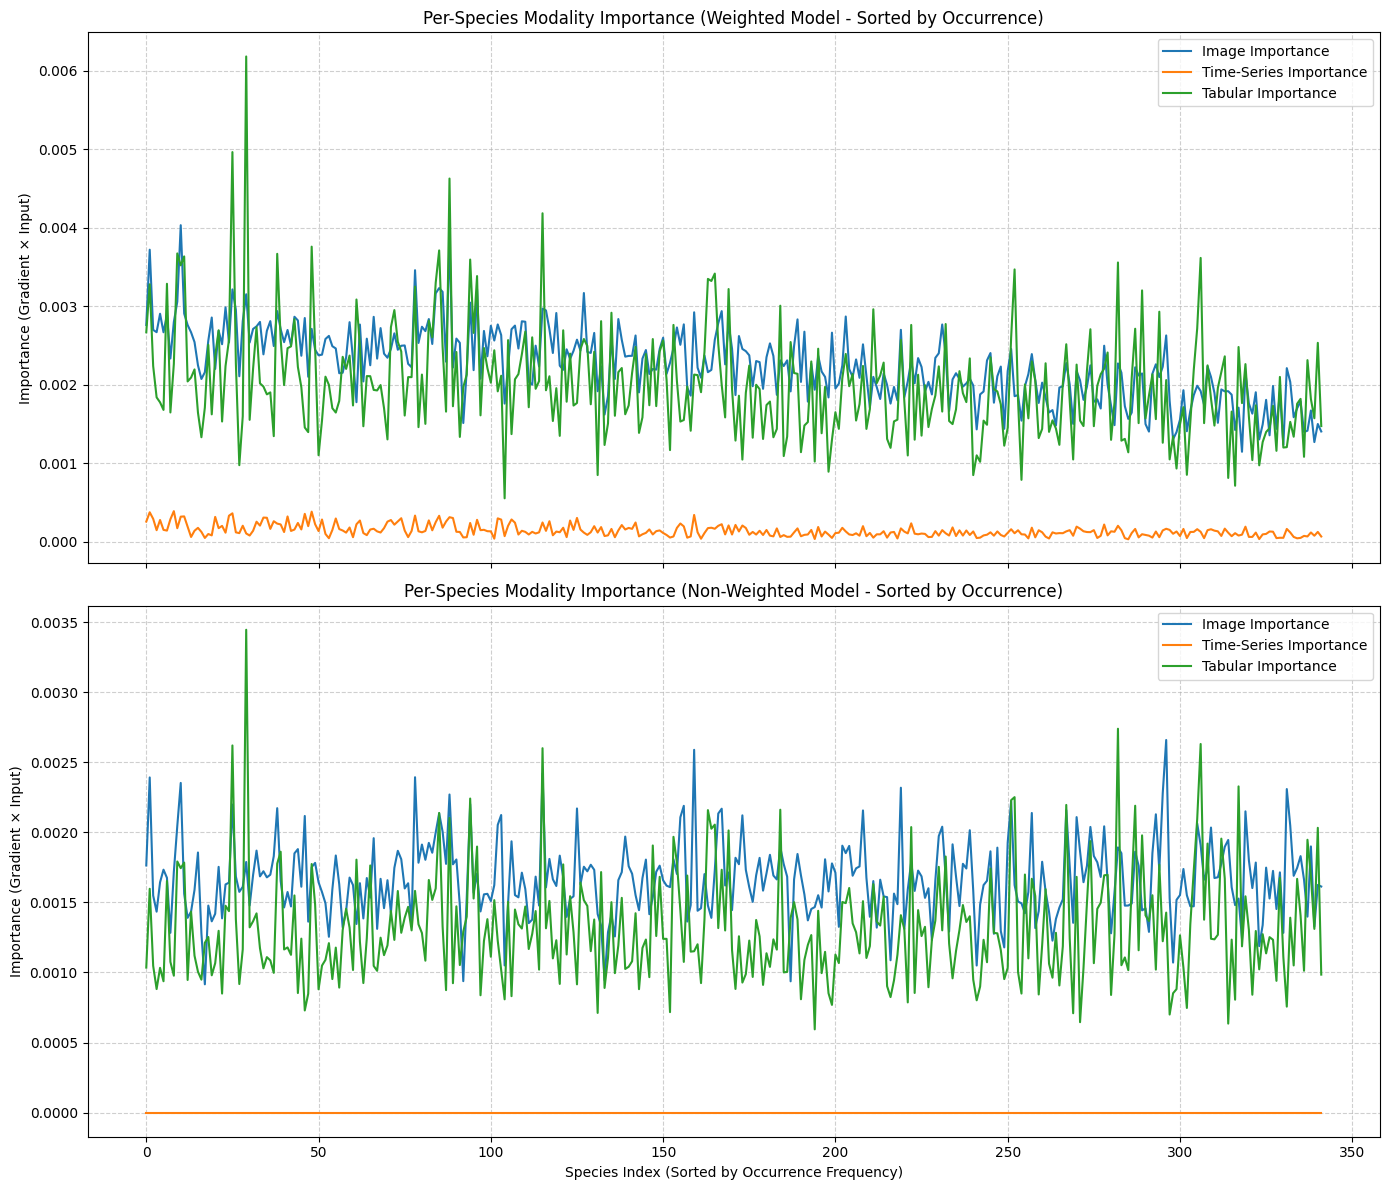

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure sorted_indices is available from previous steps (ordering by occurrence frequency)
# If not, re-run cells that define species_occurrence_counts and sorted_indices
# sorted_indices = np.argsort(species_occurrence_counts)

# Rearrange modality scores for the weighted model
rearranged_img_importance_W = np.array(modality_scores_W["image"])[sorted_indices]
rearranged_ts_importance_W = np.array(modality_scores_W["ts"])[sorted_indices]
rearranged_tab_importance_W = np.array(modality_scores_W["tabular"])[sorted_indices]

# Rearrange modality scores for the non-weighted model
rearranged_img_importance_N = np.array(modality_scores_N["image"])[sorted_indices]
rearranged_ts_importance_N = np.array(modality_scores_N["ts"])[sorted_indices]
rearranged_tab_importance_N = np.array(modality_scores_N["tabular"])[sorted_indices]

# Create subplots for better comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot for Weighted Model
axes[0].plot(rearranged_img_importance_W, label="Image Importance")
axes[0].plot(rearranged_ts_importance_W, label="Time-Series Importance")
axes[0].plot(rearranged_tab_importance_W, label="Tabular Importance")
axes[0].set_title("Per-Species Modality Importance (Weighted Model - Sorted by Occurrence)")
axes[0].set_ylabel("Importance (Gradient × Input)")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot for Non-Weighted Model
axes[1].plot(rearranged_img_importance_N, label="Image Importance")
axes[1].plot(rearranged_ts_importance_N, label="Time-Series Importance")
axes[1].plot(rearranged_tab_importance_N, label="Tabular Importance")
axes[1].set_title("Per-Species Modality Importance (Non-Weighted Model - Sorted by Occurrence)")
axes[1].set_xlabel("Species Index (Sorted by Occurrence Frequency)")
axes[1].set_ylabel("Importance (Gradient × Input)")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/ENV-540/project/Models/Initial_Multimodal/Modality_importance.png", dpi=300)
plt.show()

## Correlation Between Species Frequency and Performance Metrics

### Subtask:
Calculate and interpret the correlation between species occurrence frequency and their F1-score, recall, and precision.

**Reasoning**:
To determine if species that appear more often have higher F1-scores, recall, or precision, I will calculate the Pearson correlation coefficient between the `species_counts` (occurrence frequency) and the `f1_per_species`, `recall_per_species`, and `precision_per_species` lists. A positive correlation would indicate that more frequent species tend to have higher scores in these metrics.

In [81]:
from scipy.stats import pearsonr
import numpy as np

num_species = all_labels_W.shape[1]

precision_per_species = []
recall_per_species = []
f1_per_species = []

for i in range(num_species):
    y_true = all_labels_W[:, i]
    y_pred = tuned_binary_preds_W[:, i]

    # Calculate precision, recall, and F1-score for each species
    # zero_division=0 handles cases where there are no true positives or predicted positives
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

    precision_per_species.append(precision)
    recall_per_species.append(recall)
    f1_per_species.append(f1)

# Ensure species_counts is a 1D array
species_counts = species_train.sum(axis=0)

# Calculate correlation with F1-score
corr_f1, _ = pearsonr(species_counts, f1_per_species)
print(f"Correlation between species frequency and F1-score: {corr_f1:.4f}")

# Calculate correlation with Recall
corr_recall, _ = pearsonr(species_counts, recall_per_species)
print(f"Correlation between species frequency and Recall: {corr_recall:.4f}")

# Calculate correlation with Precision
corr_precision, _ = pearsonr(species_counts, precision_per_species)
print(f"Correlation between species frequency and Precision: {corr_precision:.4f}")

print("\nInterpretation:")
print(" - A correlation coefficient close to 1 indicates a strong positive linear relationship.")
print(" - A correlation coefficient close to -1 indicates a strong negative linear relationship.")
print(" - A correlation coefficient close to 0 indicates a weak or no linear relationship.")

Correlation between species frequency and F1-score: 0.4169
Correlation between species frequency and Recall: 0.3667
Correlation between species frequency and Precision: 0.1083

Interpretation:
 - A correlation coefficient close to 1 indicates a strong positive linear relationship.
 - A correlation coefficient close to -1 indicates a strong negative linear relationship.
 - A correlation coefficient close to 0 indicates a weak or no linear relationship.


In [82]:
def binary_thresholds(all_labels):
  return (all_labels >= 0.5).astype(int)

binary_preds_W = binary_thresholds(all_preds_W)

In [83]:
def map_predictions_species(all_preds, all_labels, species_index, test_lats, test_lons, show_types=None):
    """
    Creates a Folium map showing prediction correctness for a specific species.

    Parameters:
    - all_preds: np.array of shape (num_samples, num_species), model predictions (0/1)
    - all_labels: np.array of shape (num_samples, num_species), true labels (0/1)
    - species_index: int, index of the species to visualize
    - test_lats: list or array of latitude values
    - test_lons: list or array of longitude values
    - show_types: set of strings indicating which prediction types to show.
                  Options: 'TP', 'TN', 'FP', 'FN'
                  Default: None (show all)
    """

    print("Number of species prediction:")
    print(all_preds[:,species_index].sum())
    print("Number of species occurence:")
    print(all_labels[:,species_index].sum())

    if show_types is None:
        show_types = {'TP', 'TN', 'FP', 'FN'}  # show all by default

    center_lat = np.mean(test_lats)
    center_lon = np.mean(test_lons)
    fmap = folium.Map(location=[center_lat, center_lon], zoom_start=4)

    preds_species = all_preds[:, species_index]
    labels_species = all_labels[:, species_index]

    for lat, lon, pred, label in zip(test_lats, test_lons, preds_species, labels_species):
        # Determine prediction type and color
        if pred == 1 and label == 1:
            pred_type = 'TP'
            color = 'green'
        elif pred == 0 and label == 1:
            pred_type = 'FN'
            color = 'red'
        elif pred == 0 and label == 0:
            pred_type = 'TN'
            color = 'blue'
        else:  # pred == 1 and label == 0
            pred_type = 'FP'
            color = 'orange'

        if pred_type not in show_types:
            continue  # skip this point if not in selected types

        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.6
        ).add_to(fmap)

    return fmap

In [84]:
map_predictions_species(all_preds=binary_preds_W, all_labels=all_labels_W, species_index=30, test_lats=test_lats, test_lons=test_lons)

Number of species prediction:
112
Number of species occurence:
46.0
